In [4]:
from pprint import pprint

from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import datasets
import torch
import torch.nn
import torchmetrics.classification
from transformers import AutoImageProcessor, AutoModelForImageClassification

from armory.metrics.compute import BasicProfiler
from charmory.data import ArmoryDataLoader
from charmory.engine import EvaluationEngine
import charmory.evaluation as ev
from charmory.metrics.perturbation import PerturbationNormMetric
from charmory.model.image_classification import JaticImageClassificationModel
from charmory.perturbation import ArtEvasionAttack
from charmory.tasks.image_classification import ImageClassificationTask
from charmory.track import track_init_params, track_params
from charmory.utils import Unnormalize
import mlflow
from PIL import  Image
import os

2024-01-04 14:40:55.300379: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 14:40:55.337046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 14:40:55.337070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 14:40:55.337985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 14:40:55.344438: I tensorflow/core/platform/cpu_feature_guar

In [3]:
model = JaticImageClassificationModel(
    track_params(AutoModelForImageClassification.from_pretrained)(
        "farleyknight-org-username/vit-base-mnist"
    ),
)
classifier = track_init_params(PyTorchClassifier)(
    model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.003),
    input_shape=(3, 224, 224),
    channels_first=True,
    nb_classes=10,
    clip_values=(-1, 1),
)

config.json:   0%|          | 0.00/985 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [7]:
dataset = datasets.load_dataset("mnist", split="test")
processor = AutoImageProcessor.from_pretrained(
    "farleyknight-org-username/vit-base-mnist"
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [8]:
batch_size = 16
def transform(sample):
        # Use the HF image processor and convert from BW To RGB
        sample["image"] = processor([img.convert("RGB") for img in sample["image"]])[
            "pixel_values"
        ]
        return sample

dataset.set_transform(transform)
dataloader = ArmoryDataLoader(dataset, batch_size=batch_size)

In [11]:
attack = track_init_params(ProjectedGradientDescent)(
    classifier,
    batch_size=batch_size,
    eps=0.031,
    eps_step=0.007,
    max_iter=20,
    num_random_init=1,
    random_eps=False,
    targeted=False,
    verbose=False,
)

NameError: name 'classifier' is not defined

In [7]:
evaluation = ev.Evaluation(
    name="mnist-vit-pgd",
    description="MNIST image classification using a ViT model and PGD attack",
    author="TwoSix",
    dataset=ev.Dataset(
        name="MNIST",
        x_key="image",
        y_key="label",
        test_dataloader=dataloader,
    ),
    model=ev.Model(
        name="ViT",
        model=classifier,
    ),
    perturbations={
        "benign": [],
        "attack": [
            ArtEvasionAttack(
                name="PGD",
                attack=attack,
                use_label_for_untargeted=False,
            ),
        ],
    },
    metric=ev.Metric(
        profiler=BasicProfiler(),
        perturbation={
            "linf_norm": PerturbationNormMetric(ord=torch.inf),
        },
        prediction={
            "accuracy": torchmetrics.classification.Accuracy(
                task="multiclass", num_classes=10
            ),
        },
    ),
)


In [8]:
export_every_n_batches = 10
num_batches = 10
task = ImageClassificationTask(
        evaluation,
        export_adapter=Unnormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        export_every_n_batches=export_every_n_batches,
    )
engine = EvaluationEngine(task, limit_test_batches=num_batches)

INFO: Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [9]:
pprint(engine.run())

2024-01-04 03:28:39 22s WARNING  lightning.pytorch.loggers.mlflow:experiment:175 Experiment with name mnist-vit-pgd not found. Creating it.


2024/01/04 03:28:39 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/01/04 03:28:39 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/jonathan.prokos/.venv/armory-library/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      attack/accuracy      │    0.02500000037252903    │
│     attack/linf_norm      │    0.03100001811981201    │
│      benign/accuracy      │            1.0            │
│     benign/linf_norm      │            0.0            │
└───────────────────────────┴───────────────────────────┘

2024/01/04 03:29:19 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/01/04 03:29:19 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


{'compute': {'Avg. CPU time (s) for 10 executions of attack/perturbation': 3.6825422613183036,
             'Avg. CPU time (s) for 10 executions of attack/perturbation/PGD': 3.6825238562189044,
             'Avg. CPU time (s) for 10 executions of attack/predict': 0.08591050679096952,
             'Avg. CPU time (s) for 10 executions of benign/perturbation': 9.099836461246013e-07,
             'Avg. CPU time (s) for 10 executions of benign/predict': 0.11091956939781085},
 'metrics': {'attack/accuracy': tensor(0.0250),
             'attack/linf_norm': tensor(0.0310),
             'benign/accuracy': tensor(1.),
             'benign/linf_norm': tensor(0.)}}


In [10]:
#Simple script to retrieve 1 example of a benign and attacked image from the mlflow artifacts
mlflow_var = mlflow.search_experiments(filter_string="name = 'mnist-vit-pgd'")[0]
path = mlflow_var.artifact_location[7:] + '/' + engine.run_id + '/artifacts'
image_bin, image_adv = None, None
for f in os.listdir(path):
    if f.endswith("ex_0_x_adv.png"):
        image_adv = Image.open(os.path.join(path,f))
    elif f.endswith("ex_0_x.png"):
        image_bin = Image.open(os.path.join(path,f))

In [13]:
display(image_bin)

None

In [12]:
image_adv

# defense

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

from pprint import pprint

from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import datasets
import torch
import torch.nn
import torchmetrics.classification
from transformers import AutoImageProcessor, AutoModelForImageClassification

from armory.metrics.compute import BasicProfiler
from charmory.data import ArmoryDataLoader
from charmory.engine import EvaluationEngine
import charmory.evaluation as ev
from charmory.metrics.perturbation import PerturbationNormMetric
from charmory.model.image_classification import JaticImageClassificationModel
from charmory.perturbation import ArtEvasionAttack
from charmory.tasks.image_classification import ImageClassificationTask
from charmory.track import track_init_params, track_params
from charmory.utils import Unnormalize
import mlflow
from PIL import  Image
import os

2024-01-04 14:41:40.990945: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 14:41:41.028067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 14:41:41.028092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 14:41:41.029176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 14:41:41.036981: I tensorflow/core/platform/cpu_feature_guar

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
from art.defences.preprocessor import JpegCompression
import numpy as np


class JpegCompressionNormalized(JpegCompression):
    """
    Unnormalize inputs that were normalized during preprocessing,
    process use ART JpegCompression, and renormalize
    """

    def __init__(
        self,
        clip_values,
        quality=50,
        apply_fit=True,
        apply_predict=False,
        means=None,
        stds=None,
        dtype=np.float32,
    ):
        super().__init__(
            clip_values,
            quality=quality,
            apply_fit=apply_fit,
            apply_predict=apply_predict,
        )
        if means is None:
            means = (0.0, 0.0, 0.0)  # identity operation
        if len(means) != 3:
            raise ValueError("means must have 3 values, one per channel")
        self.means = np.array(means, dtype=dtype)

        if stds is None:
            stds = (1.0, 1.0, 1.0)  # identity operation
        if len(stds) != 3:
            raise ValueError("stds must have 3 values, one per channel")
        self.stds = np.array(stds, dtype=dtype)

    def __call__(self, x, y=None):
        x = x * self.stds + self.means
        x = torch.clamp(x, self.clip_values[0], self.clip_values[1], out=x)
        x, _ = super().__call__(x)
        x = (x - self.means) / self.stds
        return x, y


In [4]:
defended_model = JaticImageClassificationModel(
    track_params(AutoModelForImageClassification.from_pretrained)(
        "farleyknight-org-username/vit-base-mnist"
    ),
)
defended_classifier = track_init_params(PyTorchClassifier)(
    defended_model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(defended_model.parameters(), lr=0.003),
    input_shape=(3, 224, 224),
    channels_first=True,
    nb_classes=10,
    clip_values=(-1, 1),
    preprocessing_defences=JpegCompressionNormalized(clip_values=(0, 1)),
)

In [6]:
dataset = datasets.load_dataset("mnist", split="test")
processor = AutoImageProcessor.from_pretrained(
    "farleyknight-org-username/vit-base-mnist"
)

batch_size = 16
def transform(sample):
        # Use the HF image processor and convert from BW To RGB
        sample["image"] = processor([img.convert("RGB") for img in sample["image"]])[
            "pixel_values"
        ]
        return sample

dataset.set_transform(transform)
dataloader = ArmoryDataLoader(dataset, batch_size=batch_size)

attack = track_init_params(ProjectedGradientDescent)(
    defended_classifier,
    batch_size=batch_size,
    eps=0.031,
    eps_step=0.007,
    max_iter=20,
    num_random_init=1,
    random_eps=False,
    targeted=False,
    verbose=False,
)

evaluation = ev.Evaluation(
    name="mnist-vit-pgd",
    description="MNIST image classification using a ViT model and PGD attack",
    author="TwoSix",
    dataset=ev.Dataset(
        name="MNIST",
        x_key="image",
        y_key="label",
        test_dataloader=dataloader,
    ),
    model=ev.Model(
        name="ViT",
        model=defended_classifier,
    ),
    perturbations={
        "benign": [],
        "attack": [
            ArtEvasionAttack(
                name="PGD",
                attack=attack,
                use_label_for_untargeted=False,
            ),
        ],
    },
    metric=ev.Metric(
        profiler=BasicProfiler(),
        perturbation={
            "linf_norm": PerturbationNormMetric(ord=torch.inf),
        },
        prediction={
            "accuracy": torchmetrics.classification.Accuracy(
                task="multiclass", num_classes=10
            ),
        },
    ),
)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [7]:
export_every_n_batches = 10
num_batches = 10
task = ImageClassificationTask(
        evaluation,
        export_adapter=Unnormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        export_every_n_batches=export_every_n_batches,
    )
engine = EvaluationEngine(task, limit_test_batches=num_batches)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [8]:
pprint(engine.run())

2024/01/04 14:42:06 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/01/04 14:42:06 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]
/home/jonathan.prokos/.venv/armory-library/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      attack/accuracy      │    0.01875000074505806    │
│     attack/linf_norm      │    0.03100001811981201    │
│      benign/accuracy      │            1.0            │
│     benign/linf_norm      │            0.0            │
└───────────────────────────┴───────────────────────────┘

2024/01/04 14:42:55 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/01/04 14:42:55 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


{'compute': {'Avg. CPU time (s) for 10 executions of attack/perturbation': 4.577530871808994,
             'Avg. CPU time (s) for 10 executions of attack/perturbation/PGD': 4.5775056462967765,
             'Avg. CPU time (s) for 10 executions of attack/predict': 0.06750844309572131,
             'Avg. CPU time (s) for 10 executions of benign/perturbation': 1.0430114343762397e-06,
             'Avg. CPU time (s) for 10 executions of benign/predict': 0.09311871371464804},
 'metrics': {'attack/accuracy': tensor(0.0188),
             'attack/linf_norm': tensor(0.0310),
             'benign/accuracy': tensor(1.),
             'benign/linf_norm': tensor(0.)}}


In [19]:
#Simple script to retrieve 1 example of a benign and attacked image from the mlflow artifacts
mlflow_var = mlflow.search_experiments(filter_string="name = 'mnist-vit-pgd'")[0]
path = mlflow_var.artifact_location[7:] + '/' + engine.run_id + '/artifacts'
image_bin, image_adv = None, None
print(os.listdir(path))
for f in os.listdir(path):
    if f.endswith("attack.png"):
        image_adv = Image.open(os.path.join(path,f))
    elif f.endswith("benign.png"):
        image_bin = Image.open(os.path.join(path,f))
    if image_adv is not None and image_bin is not None:
        break


['batch_9_ex_8_attack.png', 'batch_9_ex_4_benign.txt', 'batch_9_ex_7_attack.txt', 'batch_9_ex_12_benign.txt', 'batch_9_ex_11_attack.txt', 'batch_9_ex_15_attack.png', 'batch_9_ex_3_attack.png', 'batch_9_ex_0_benign.png', 'batch_9_ex_11_benign.png', 'batch_9_ex_12_attack.png', 'batch_9_ex_8_benign.txt', 'batch_9_ex_7_benign.png', 'batch_9_ex_4_attack.png', 'batch_9_ex_0_attack.txt', 'batch_9_ex_3_benign.txt', 'batch_9_ex_15_benign.txt', 'batch_9_ex_13_attack.txt', 'batch_9_ex_10_benign.txt', 'batch_9_ex_9_benign.png', 'batch_9_ex_5_attack.txt', 'batch_9_ex_6_benign.txt', 'batch_9_ex_2_benign.png', 'batch_9_ex_1_attack.png', 'batch_9_ex_14_benign.png', 'batch_9_ex_9_attack.txt', 'batch_9_ex_6_attack.png', 'batch_9_ex_5_benign.png', 'batch_9_ex_10_attack.png', 'batch_9_ex_13_benign.png', 'batch_9_ex_14_attack.txt', 'batch_9_ex_1_benign.txt', 'batch_9_ex_2_attack.txt', 'batch_9_ex_11_attack.png', 'batch_9_ex_12_benign.png', 'batch_9_ex_7_attack.png', 'batch_9_ex_4_benign.png', 'batch_9_ex_8

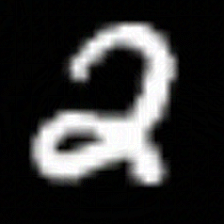

In [21]:
image_adv

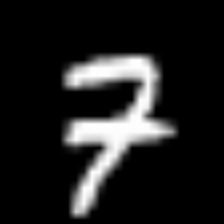

In [22]:
image_bin